In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   228M      0  0:00:03  0:00:03 --:--:--  228M


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [6]:
!ls PetImages

Cat  Dog


In [7]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [8]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


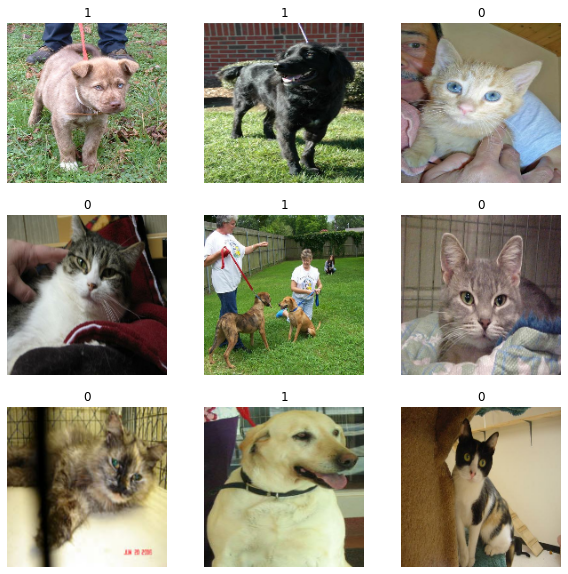

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
def model_train(epochs):
  callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
  ]
  model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
  )
  model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
  )

In [14]:
train25 = model_train(25)
train25

Epoch 1/25
586/586 [==============================] - 185s 316ms/step - loss: 0.6079 - accuracy: 0.6806 - val_loss: 0.7004 - val_accuracy: 0.6096
Epoch 2/25
586/586 [==============================] - 186s 318ms/step - loss: 0.4436 - accuracy: 0.7935 - val_loss: 0.3912 - val_accuracy: 0.8255
Epoch 3/25
586/586 [==============================] - 187s 319ms/step - loss: 0.3609 - accuracy: 0.8405 - val_loss: 0.3211 - val_accuracy: 0.8535
Epoch 4/25
586/586 [==============================] - 185s 316ms/step - loss: 0.2942 - accuracy: 0.8765 - val_loss: 0.3280 - val_accuracy: 0.8678
Epoch 5/25
586/586 [==============================] - 183s 313ms/step - loss: 0.2417 - accuracy: 0.8997 - val_loss: 0.2769 - val_accuracy: 0.8802
Epoch 6/25
586/586 [==============================] - 183s 312ms/step - loss: 0.2142 - accuracy: 0.9119 - val_loss: 0.5650 - val_accuracy: 0.8035
Epoch 7/25
586/586 [==============================] - 182s 311ms/step - loss: 0.2002 - accuracy: 0.9174 - val_loss: 0.1616 -

In [15]:
train50 = model_train(50)
train50

Epoch 1/50
586/586 [==============================] - 184s 313ms/step - loss: 0.0879 - accuracy: 0.9646 - val_loss: 0.1251 - val_accuracy: 0.9496
Epoch 2/50
586/586 [==============================] - 183s 313ms/step - loss: 0.0858 - accuracy: 0.9658 - val_loss: 0.2009 - val_accuracy: 0.9212
Epoch 3/50
586/586 [==============================] - 184s 314ms/step - loss: 0.0792 - accuracy: 0.9690 - val_loss: 0.1105 - val_accuracy: 0.9607
Epoch 4/50
586/586 [==============================] - 183s 313ms/step - loss: 0.0817 - accuracy: 0.9682 - val_loss: 0.0928 - val_accuracy: 0.9667
Epoch 5/50
586/586 [==============================] - 184s 314ms/step - loss: 0.0802 - accuracy: 0.9673 - val_loss: 0.1170 - val_accuracy: 0.9571
Epoch 6/50
586/586 [==============================] - 184s 313ms/step - loss: 0.0778 - accuracy: 0.9701 - val_loss: 0.1440 - val_accuracy: 0.9481
Epoch 7/50
586/586 [==============================] - 184s 314ms/step - loss: 0.0751 - accuracy: 0.9696 - val_loss: 0.1167 -

In [16]:
model.save("pet_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pet_model/assets


In [18]:
import shutil
shutil.make_archive("pet_model", 'zip', "pet_model")

'/content/pet_model.zip'

In [28]:
url = input('Enter URL: ')

Enter URL: https://upload.wikimedia.org/wikipedia/commons/d/dd/Golden_Retriever_Hund_Dog.JPG


In [29]:
import urllib.request
urllib.request.urlretrieve(url,'pet.jpg')

('pet.jpg', <http.client.HTTPMessage at 0x7fa902bb0978>)



This image is 0.00 percent cat and 100.00 percent dog.


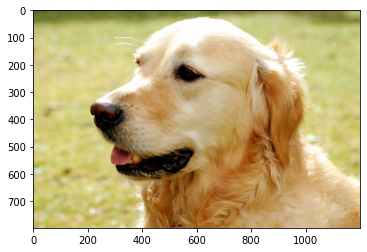

In [31]:
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('pet.jpg'))

load_model = keras.models.load_model('pet_model')
img = keras.preprocessing.image.load_img(
    "pet.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = load_model.predict(img_array)
score = predictions[0]
print(
    "\n\nThis image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)